In [1]:
import networkx as nx
import random
import numpy as np
import pandas as pd
from network_build import *
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load data
driver = pd.read_csv("..//..//..//Database//NYC_trip//driver_260.csv", index_col=0)
order = pd.read_csv("..//..//..//Database//NYC_trip//order_clean_260.csv", index_col=0)
area = np.load("..//..//..//Database//NYC_area//NY_area.npy")

In [3]:
# subnetwork setting
interval = 60
time_list = ['6-7am', '7-8am', '8-9am', '9-10am', '6-10am']

# xtick label format setting

hours = list(range(24 + 1))
hourlabels = [f"{h:02d}:{00:02d}" for h in hours]  # ["00:00", "01:00", ... "23:00", "24:00"]

# create driver's pick up time
order["call_time"] = pd.to_datetime(order["call_time"])
order["end_time"] = pd.to_datetime(order["end_time"])
start_time = pd.to_datetime("2022-06-01 06:00:00 AM")
driver["time"] = pd.date_range(start=start_time, end=start_time, periods=len(driver))
driver.columns = ["id", "time"]
driver_pick = driver.values

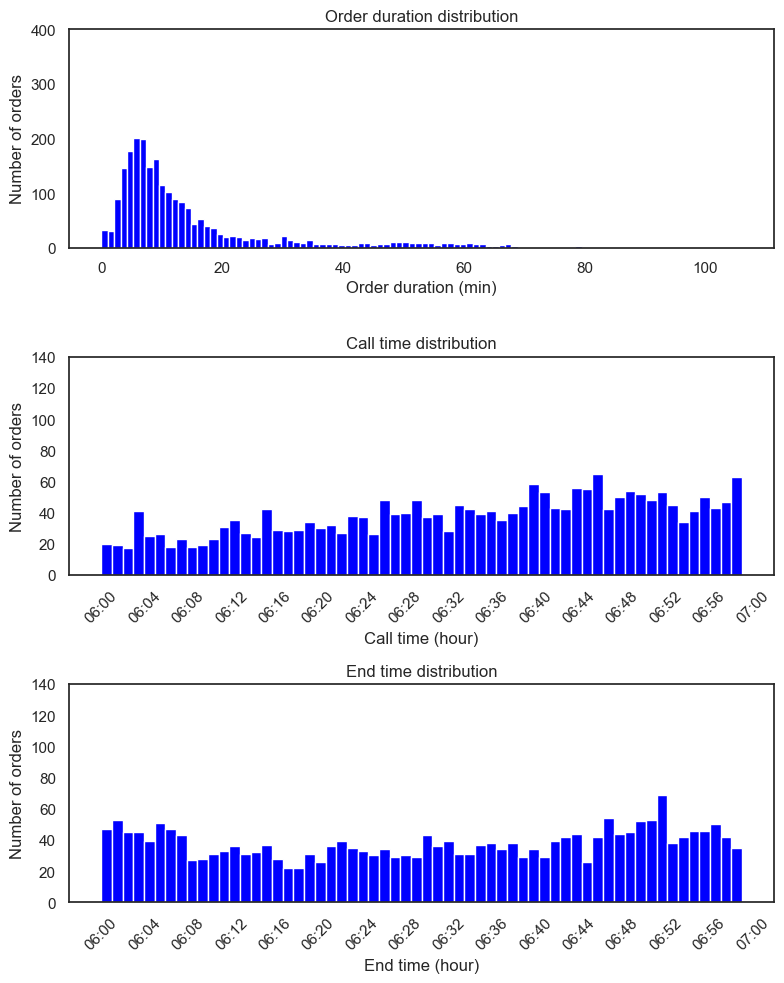

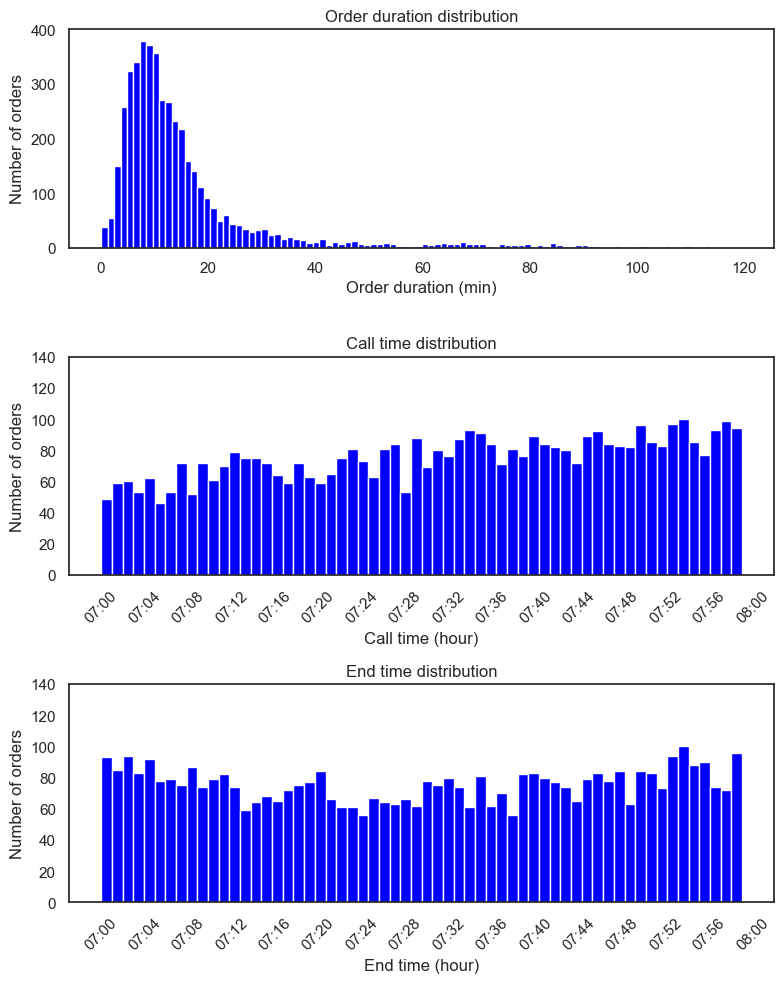

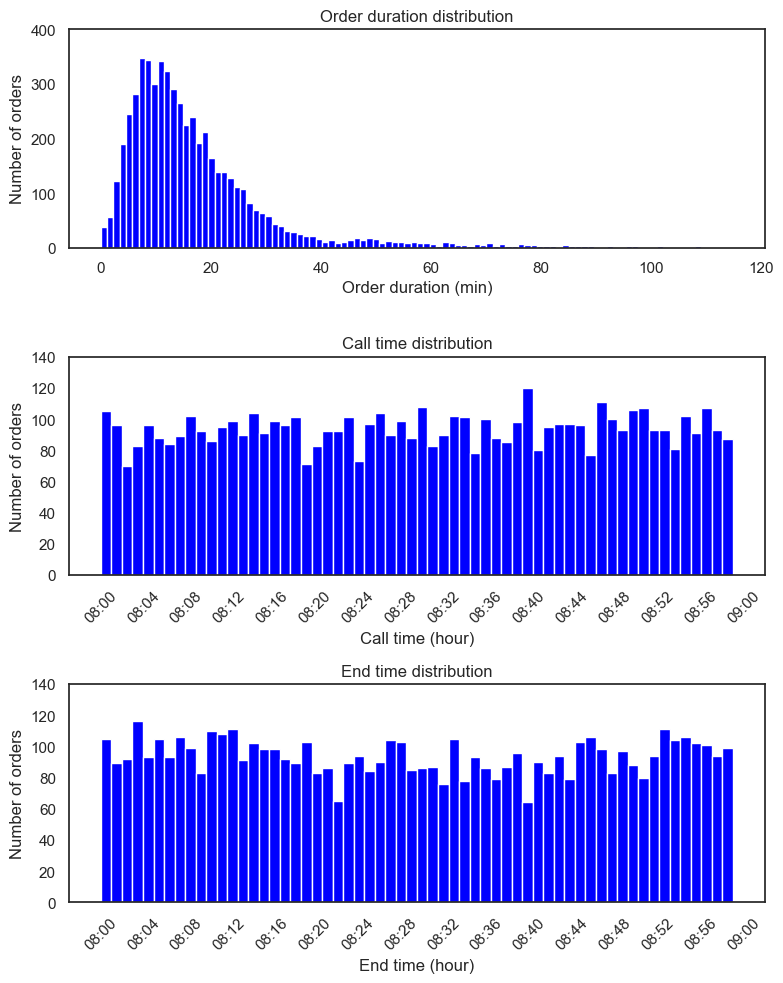

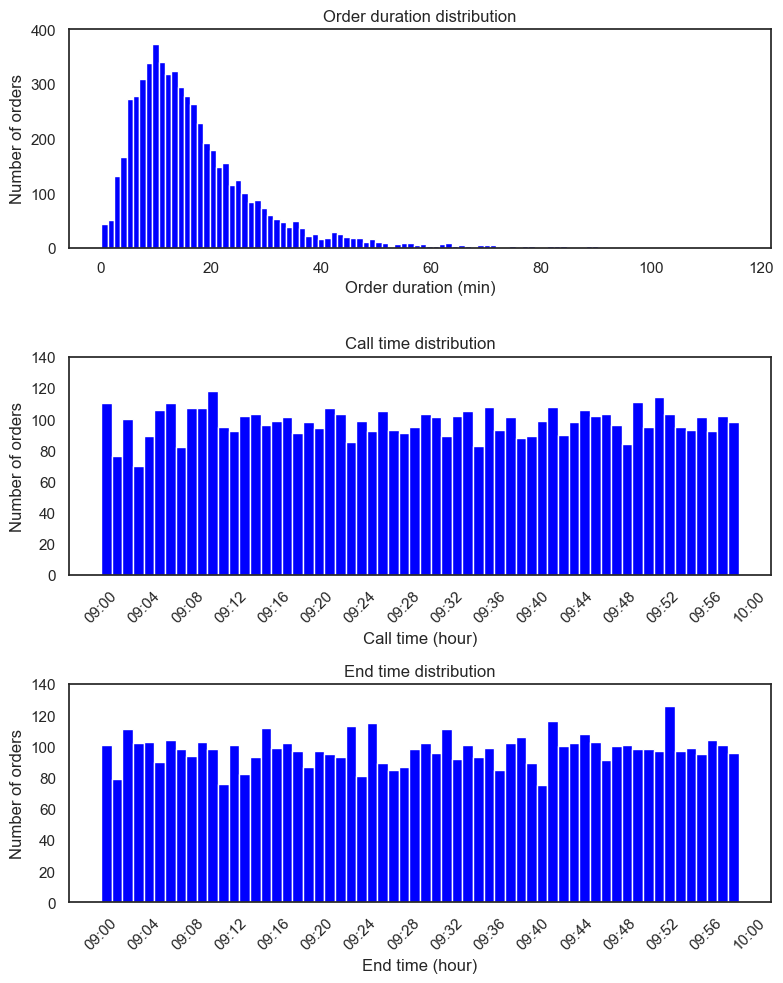

In [4]:
for i in range(4):
    start_time = pd.to_datetime("2022-06-01 06:00:00 AM") + pd.Timedelta(minutes=i*interval)
    end_time = pd.to_datetime("2022-06-01 06:00:00 AM") + pd.Timedelta(minutes=(i+1)*interval)
    order_pick = order[(order["call_time"] > start_time) & (order["call_time"] <= end_time)]
    order_pick = order_pick[["sid", "call_time", "eid", "end_time"]]

    order_pick['delta'] = (pd.to_datetime(order_pick['end_time']) - pd.to_datetime(order_pick['call_time'])).dt.total_seconds()
    order_pick['delta_min'] = order_pick['delta'].apply(lambda x: x/60)

    sns.set(style="white")


    minutes = list(range(60 +1))
    current_hour = 6 + i 
    minutelabels = [f"{current_hour:02d}:{m:02d}" for m in minutes[:-1]]
    minutelabels.append(f"{current_hour+1:02d}:{00:02d}")

    fig, ax = plt.subplots(3, 1, figsize=(8, 10), tight_layout=True)

    ax[0].hist(order_pick['delta_min'], bins=100, color='blue')
    ax[0].set_xlabel('Order duration (min)')
    ax[0].set_ylabel('Number of orders')
    ax[0].set_title('Order duration distribution')
    ax[0].set_ylim(0, 400)

    step = 4
    ax[1].hist([t.minute for t in pd.to_datetime(order_pick['call_time'])], bins = 60, color='blue')
    ax[1].set_xticks(minutes[::step], labels=minutelabels[::step], rotation=45)
    ax[1].set_xlabel('Call time (hour)')
    ax[1].set_ylabel('Number of orders')
    ax[1].set_title('Call time distribution')
    ax[1].set_ylim(0, 140)

    ax[2].hist([t.minute for t in pd.to_datetime(order_pick['end_time'])], bins = 60, color='blue')
    ax[2].set_xticks(minutes[::step], labels=minutelabels[::step], rotation=45)
    ax[2].set_xlabel('End time (hour)')
    ax[2].set_ylabel('Number of orders')
    ax[2].set_title('End time distribution')
    ax[2].set_ylim(0, 140)

    plt.savefig("..//..//..//Database//fig//order_duration_%s.png"%time_list[i], dpi=300)
    

# Construct network and save

In [5]:
# Only consider order nodes
df_list = []

# create hourly network
for i in range(4):
    start_time = pd.to_datetime("2022-06-01 06:00:00 AM") + pd.Timedelta(minutes=i*interval)
    end_time = pd.to_datetime("2022-06-01 06:00:00 AM") + pd.Timedelta(minutes=(i+1)*interval)
    order_pick = order[(order["call_time"] > start_time) & (order["call_time"] <= end_time)]
    order_pick = order_pick[["sid", "call_time", "eid", "end_time"]]
    order_pick = order_pick.values
    

    net = ConstructNetwork(order_pick, driver_pick, area, void = 10)
    G_order = net.build_network(network_type="order")
    net.saveNetwork(G_order, "..//..//..//Database//network//order_%s.gpickle"%time_list[i])
    df = net.network_metrics(G_order)
    df["time"] = time_list[i]
    df_list.append(df)

# create 4-hour network
start_time = pd.to_datetime("2022-06-01 06:00:00 AM") 
end_time = pd.to_datetime("2022-06-01 10:00:00 AM")
order_pick = order[(order["call_time"] > start_time) & (order["call_time"] <= end_time)]
order_pick = order_pick[["sid", "call_time", "eid", "end_time"]]
order_pick = order_pick.values

net = ConstructNetwork(order_pick, driver_pick, area, void = 10)
G_order = net.build_network(network_type="order")
net.saveNetwork(G_order, "..//..//..//Database//network//order_%s.gpickle"%time_list[-1])
df_4h = net.network_metrics(G_order)
df_4h["time"] = time_list[-1]
df_list.append(df_4h)

TypeError: degree_centrality() got an unexpected keyword argument 'normalized'

In [ ]:
df_all = pd.concat(df_list, axis=0)
df_all.to_csv("..//..//..//Database//network//network_metrics.csv")

# Read files, read network

In [26]:
df_all = pd.read_csv("..//..//..//Database//network//network_metrics.csv", index_col=0)
G_order_6_10 = nx.read_gpickle("..//..//..//Database//network//order_6-10am.gpickle")
G_order_6_7 = nx.read_gpickle("..//..//..//Database//network//order_6-7am.gpickle")
G_order_7_8 = nx.read_gpickle("..//..//..//Database//network//order_7-8am.gpickle")
G_order_8_9 = nx.read_gpickle("..//..//..//Database//network//order_8-9am.gpickle")
G_order_9_10 = nx.read_gpickle("..//..//..//Database//network//order_9-10am.gpickle")

In [30]:
G_list = [G_order_6_10]

for G in G_list:
    G.add_node('sink')
    for node in G.nodes():
        if node != 'sink':
            G.add_edge(node, 'sink', weight=0)

In [57]:
def single_source_longest_dag_path_length(graph, s):
    assert(graph.in_degree(s) == 0)
    dist = dict.fromkeys(graph.nodes, -float('inf'))
    dist[s] = 0
    topo_order = nx.topological_sort(graph)
    for n in topo_order:
        for s in graph.successors(n):
            if dist[s] < dist[n] + graph.edges[n,s]['weight']:
                dist[s] = dist[n] + graph.edges[n,s]['weight']
    return dist

def single_sink_longest_dag_path(graph, s):
    assert(graph.out_degree(s) == 0)
    dist = dict.fromkeys(graph.nodes, -float('inf'))
    dist[s] = 0
    topo_order = list(reversed(list(nx.topological_sort(graph))))
    for n in topo_order:
        for s in graph.predecessors(n):
            if dist[s] < dist[n] + 1:
                dist[s] = dist[n] + 1
    return dist

MTC = single_sink_longest_dag_path(G_order_6_10, 'sink')

In [52]:
# Naive method to find the longest path in a DAG (very expensive)
# MTC = {}
# for G in G_list:
#     for node in ['t0', 't7', 't8', 't9', 't39', 't40', 't41', 't42']:
#         MTC[node] = len(max(nx.all_simple_paths(G, node, 'sink'), key=lambda x: len(x))) - 1
# MTC

In [58]:
df_all['MTC'] = df_all.index.map(MTC)

df_all

,degree_centrality,betweenness_centrality,closeness_centrality,katz_centrality,time,MTC
t0,0.014499,0.000000,0.000000,1.280767e-03,6-7am,2
t1,0.000439,0.000439,0.000000,1.408844e-03,6-7am,50
t2,0.000879,0.002009,0.000000,1.616328e-03,6-7am,29
t3,0.006151,0.039864,0.000000,5.979855e-03,6-7am,25
t4,0.014060,0.132117,0.000071,2.395040e-02,6-7am,14
...,...,...,...,...,...,...
t18299,0.004426,0.158258,0.000028,1.550827e-05,6-10am,5
t18300,0.008359,0.061754,0.000270,2.627228e-09,6-10am,23
t18301,0.005573,0.099855,0.000083,1.032761e-07,6-10am,14
t18302,0.002677,0.239574,0.000000,1.579900e-02,6-10am,1


In [ ]:
time_list = ['6-7am', '7-8am', '8-9am', '9-10am', '6-10am']
df_4h = df_all[df_all['time'] == time_list[-1]]
df_list = []
for i in range(len(time_list)-1):
    df_temp = df_all[df_all['time'] == time_list[i]]
    df_temp['full_network'] = False
    df_temp1 = df_4h[df_4h.index.isin(df_temp.index)]
    df_temp1['time'] = time_list[i]
    df_temp1['full_network'] = True
    df_list.append(df_temp)
    df_list.append(df_temp1)

C:\Users\RTW\AppData\Local\Temp\ipykernel_25004\4272869167.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['full_network'] = False
C:\Users\RTW\AppData\Local\Temp\ipykernel_25004\4272869167.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp1['time'] = time_list[i]
C:\Users\RTW\AppData\Local\Temp\ipykernel_25004\4272869167.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [ ]:
df_all_new = pd.concat(df_list, axis=0)

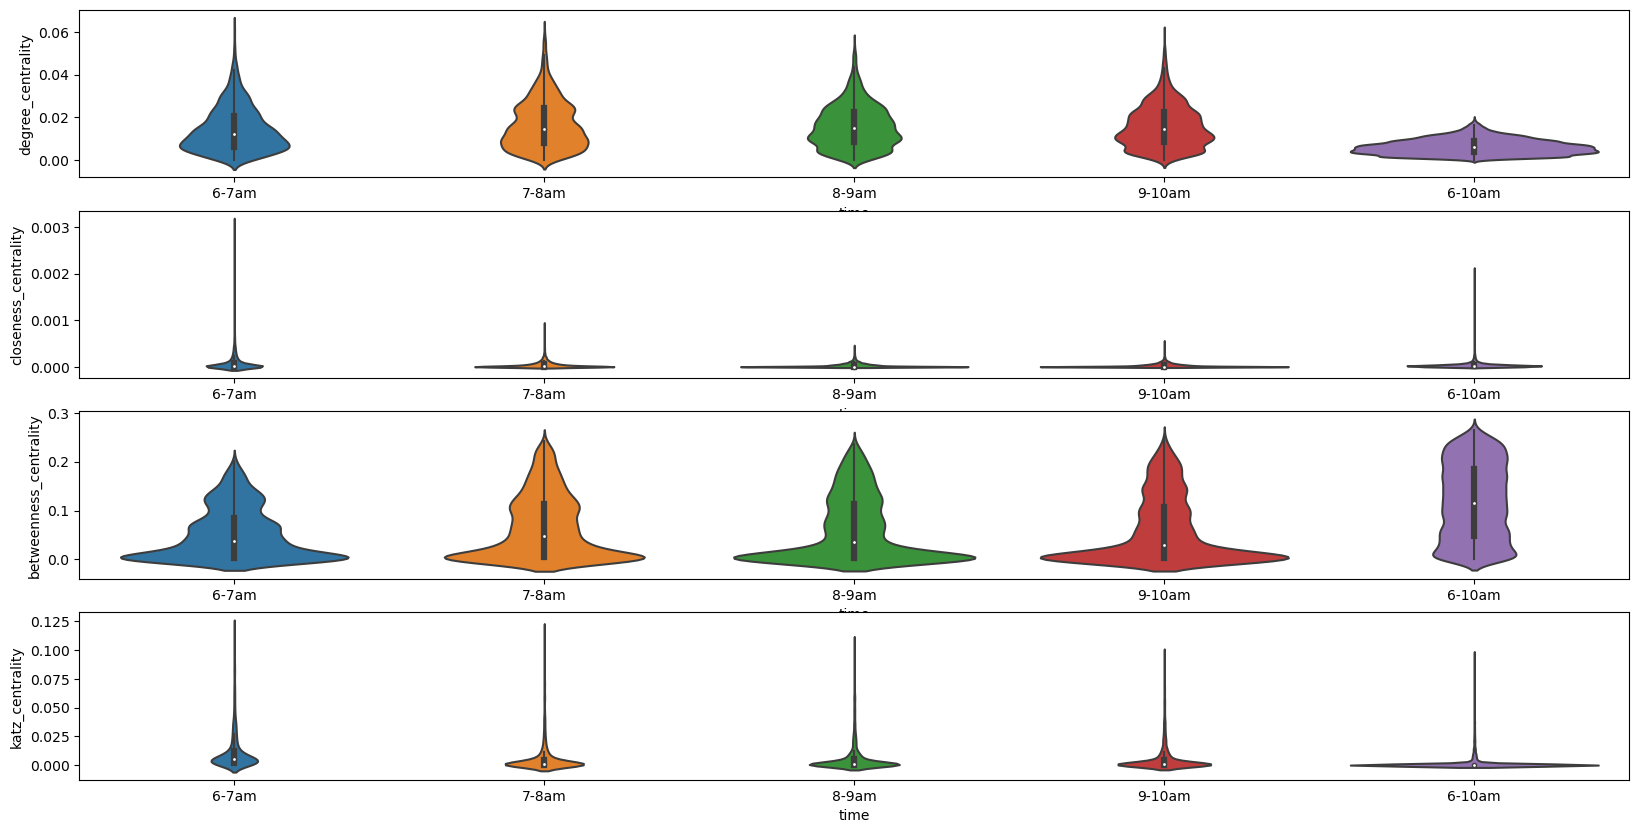

In [ ]:
figure, axes = plt.subplots(4, 1, figsize=(20, 10))
axes = axes.flatten()
sns.violinplot(x="time", y="degree_centrality", data=df_all, ax=axes[0], fill=False)
sns.violinplot(x="time", y="closeness_centrality", data=df_all, ax=axes[1])
sns.violinplot(x="time", y="betweenness_centrality", data=df_all, ax=axes[2])
sns.violinplot(x="time", y="katz_centrality", data=df_all, ax=axes[3])
plt.show()

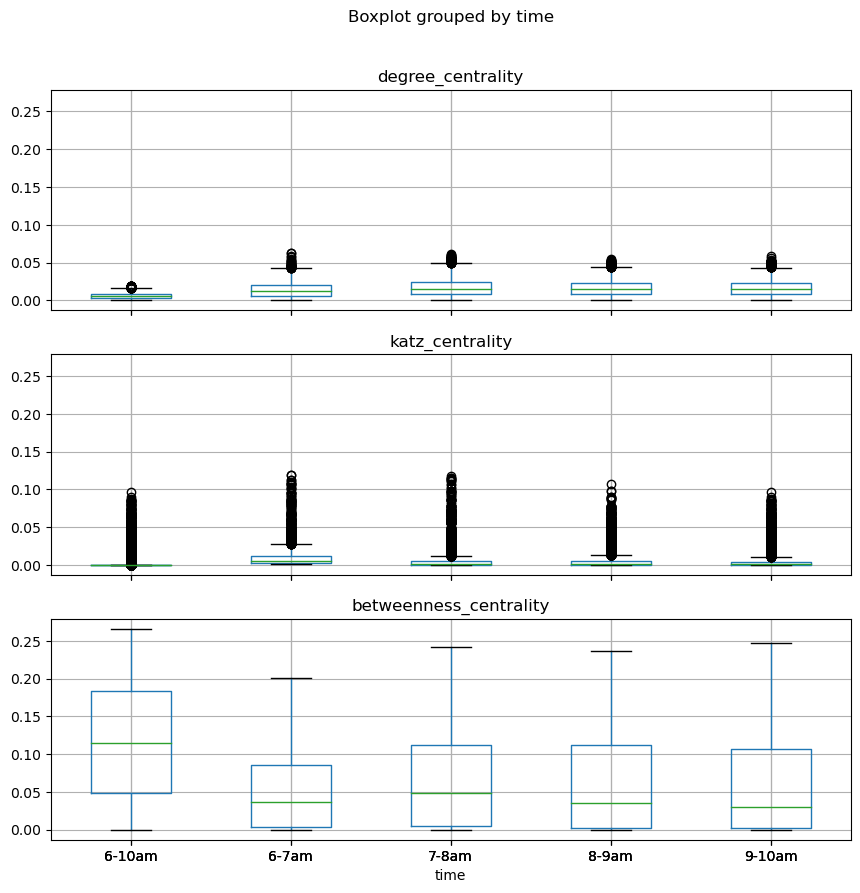

In [ ]:
df_all.boxplot(column=["degree_centrality", "katz_centrality", "betweenness_centrality"], by="time", figsize=(10, 10), layout=(3, 1))
plt.show()

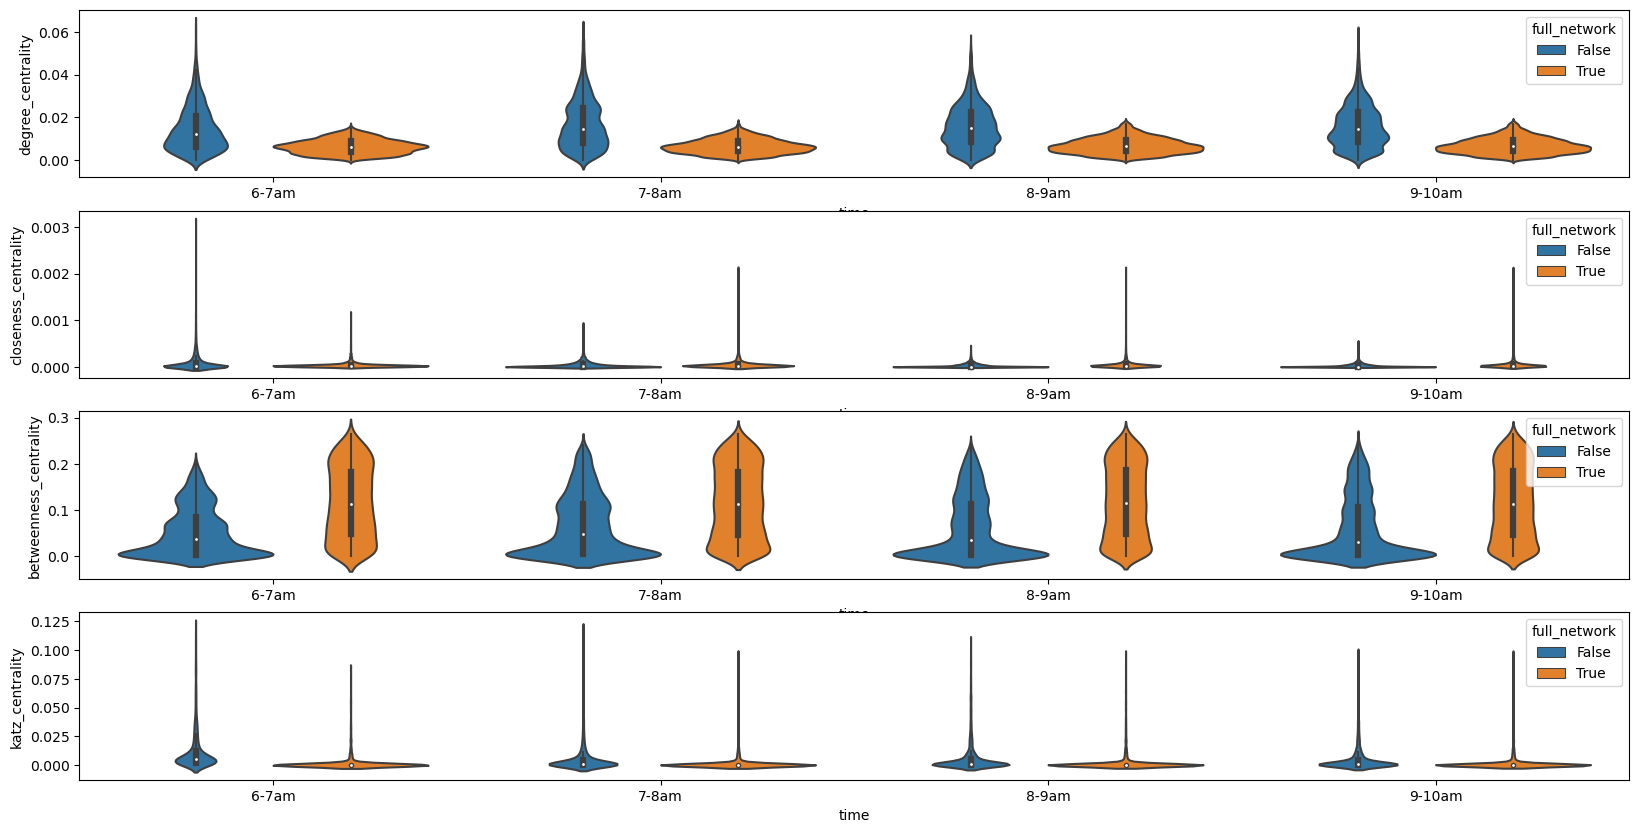

In [ ]:
figure, axes = plt.subplots(4, 1, figsize=(20, 10))
axes = axes.flatten()
sns.violinplot(x="time", y="degree_centrality", data=df_all_new, hue='full_network', ax=axes[0], fill=False)
sns.violinplot(x="time", y="closeness_centrality", data=df_all_new, hue='full_network',  ax=axes[1])
sns.violinplot(x="time", y="betweenness_centrality", data=df_all_new, hue='full_network', ax=axes[2])
sns.violinplot(x="time", y="katz_centrality", data=df_all_new, hue='full_network', ax=axes[3])
plt.show()

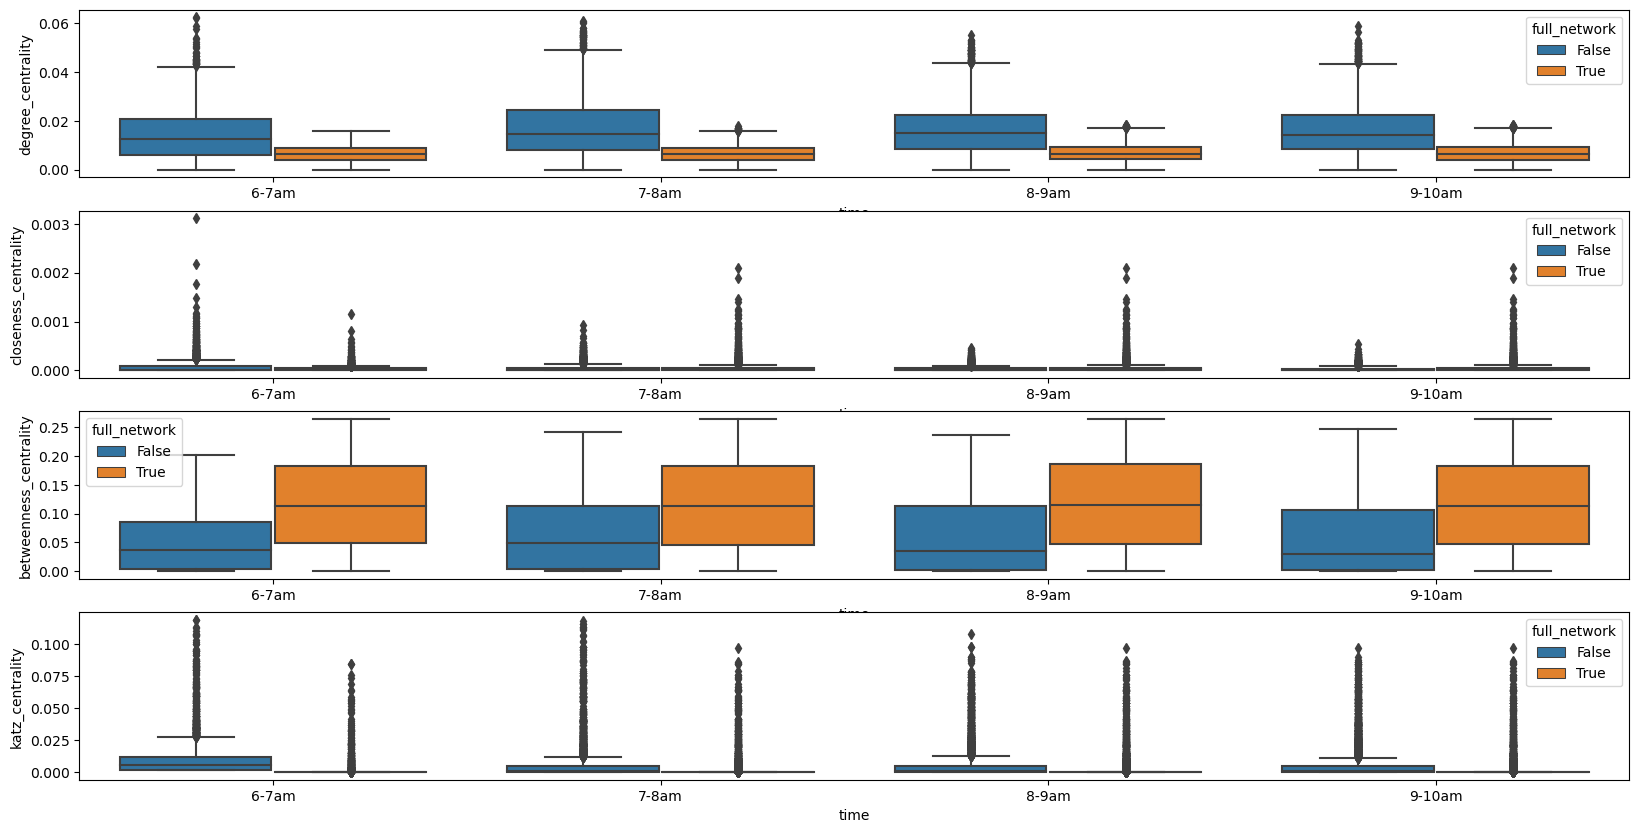

In [ ]:
figure, axes = plt.subplots(4, 1, figsize=(20, 10))
axes = axes.flatten()
sns.boxplot(x="time", y="degree_centrality", data=df_all_new, hue='full_network', ax=axes[0])
sns.boxplot(x="time", y="closeness_centrality", data=df_all_new, hue='full_network',  ax=axes[1])
sns.boxplot(x="time", y="betweenness_centrality", data=df_all_new, hue='full_network', ax=axes[2])
sns.boxplot(x="time", y="katz_centrality", data=df_all_new, hue='full_network', ax=axes[3])
plt.show()